In [45]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import japanize_matplotlib
from scipy.linalg import expm
from scipy.stats import norm
from math import factorial
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import pandas as pd
import tqdm
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import beta
pd.set_option('display.float_format', lambda x: f'{x:.7f}')


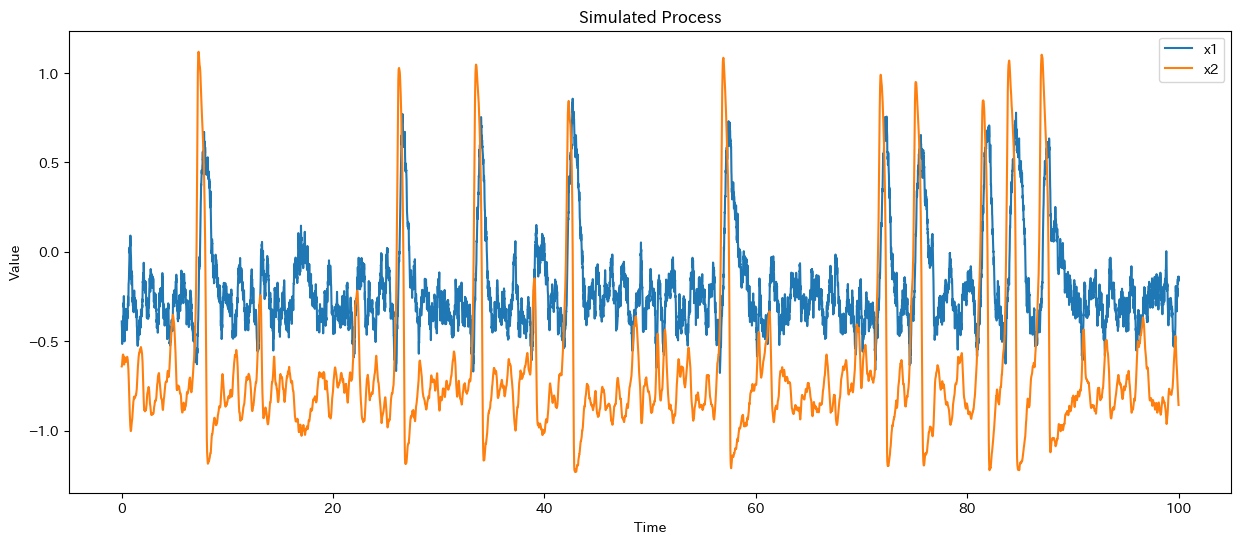

In [40]:
pandas2ri.activate()
yuima = importr("yuima")

def linear_Z(theta, t_max, dt, seed):
    theta1, theta21, theta22, theta31, theta32 = theta

    # Pythonの変数をRに渡す
    ro.r.assign("theta1", theta1)
    ro.r.assign("theta21", theta21)
    ro.r.assign("theta22", theta22)
    ro.r.assign("theta31", theta31)
    ro.r.assign("theta32", theta32)

    ro.r('options(warn=-1)')
    ro.r('drift = c("theta21*x2-x1 + theta22", "(x2- x2**3 -x1 + theta32)/theta31")')
    ro.r('diffusion = matrix(c("theta1", "0", "0", "0"), 2, 2)')
    ro.r('model = setModel(drift=drift, diffusion=diffusion, state.var=c("x1", "x2"))')

    N = int(t_max / dt)
    ro.r.assign("N", N)
    ro.r.assign("t_max", t_max)
    ro.r('samp = setSampling(Terminal=t_max, n=N)')
    ro.r('yuima = setYuima(model=model, sampling=samp)')
    
    ro.r(f'set.seed({seed})')

    # 初期値を(0,0)に設定
    ro.r('xinit = c(0, 0)')
    
    ro.r('true.par = list(theta1=theta1, theta21=theta21, theta22=theta22, theta31=theta31, theta32=theta32)')
    ro.r('sim = simulate(yuima, xinit=xinit, true.par=true.par)')
    
    Z_t = ro.r('sim@data@original.data')
    return Z_t.T

# 使用例
theta = [0.3,1.5,0.8,0.1,0.0]
t_max = 100.0  # 最大時間
burn_out = 50.0  # バーンイン
dt = 0.001  # タイムステップ
seed = 0  # ランダムシード
h = 0.01
Z_t = linear_Z(theta, t_max + burn_out, dt, seed)
Z_t = Z_t[:,int(burn_out / dt) :]
Z = Z_t[:, ::int(h / dt)]
# プロット
time_points = np.linspace(0, t_max, int(t_max / h) + 1)
plt.figure(figsize=(15, 6))
plt.plot(time_points,Z[0], label='x1')
plt.plot(time_points,Z[1], label='x2')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Simulated Process')
plt.show()
# #図形のサイズを変更


In [41]:
import sympy as sp
import numpy as np

# 変数とパラメータの定義
x, y = sp.symbols('x y')
theta_1, theta_21, theta_22, theta_31, theta_32 = sp.symbols('theta_1 theta_21 theta_22 theta_31 theta_32')

# 演算子Lの定義
def L(f):
    return (theta_21 * y - x + theta_22) * sp.diff(f, x) + \
           (1 / theta_31) * (y - y**3 - x + theta_32) * sp.diff(f, y) + \
           (1 / 2) * theta_1**2 * sp.diff(f, x, x)

# キャッシュを使って演算子を適用する関数
op_cache = {}
def apply_operator(f, k):
    # 式の文字列表現をキャッシュキーに使用する
    f_key = sp.srepr(f)

    # キャッシュがすでに存在する場合、その結果を返す
    if (f_key, k) in op_cache:
        return op_cache[(f_key, k)]

    # 初期状態のキャッシュ保存
    if k == 0:
        op_cache[(f_key, k)] = f
    else:
        # 再帰的に演算子を適用してキャッシュする
        op_cache[(f_key, k)] = L(apply_operator(f, k - 1))

    return op_cache[(f_key, k)]

# 関数をキャッシュして数値計算用に変換する
func_cache = {}
def func(f, k):
    # 式の文字列表現をキャッシュキーに使用する
    f_key = sp.srepr(f)

    # キャッシュが存在する場合、それを返す
    if (f_key, k) in func_cache:
        return func_cache[(f_key, k)]

    # シンボルをリストとして定義
    theta_symbols = (theta_1, theta_21, theta_22, theta_31, theta_32)

    # lambdify を使用して数値関数に変換
    F = apply_operator(f, k)
    numeric_func = sp.lambdify((x, y) + theta_symbols, F)

    # 数値関数をキャッシュ
    func_cache[(f_key, k)] =  lambda x_val, y_val, theta_values: numeric_func(x_val, y_val, *theta_values)/factorial(k)
    return func_cache[(f_key, k)]

# キャッシュをクリアする関数
def clear_cache():
    op_cache.clear()
    func_cache.clear()

# 利用例
# 初期関数 x に演算子を 3 回適用し、その結果を数値計算用に変換
f = x
k = 3

# apply_operator を使用して演算子を適用
f_result = apply_operator(f, k)

# 数値結果を計算
x_val = 1.0
y_val = 2.0
theta_values = [0.3, 1.5, 0.8, 0.1, 0.0]
result = func(f, k)(x_val, y_val, theta_values)
print("Result:", result)

# キャッシュをクリアする
clear_cache()

Result: 1935.9666666666665


In [ ]:

def update_1_b(theta_, Z, k0, h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    theta1_new = np.sum((x_current - x_previous)**2 /h)
    for j in range(1, k0 + 1):
        theta1_new -=(h**j) *  np.sum(func(x,j+1)(x_previous, y_previous, theta_) - 2*x_previous*func(x,j+1) (x_previous, y_previous, theta_) )

    theta1_new /= len(x_current)
    if theta1_new < 0:
        theta1_new = 0
    else:
        theta1_new = np.sqrt(theta1_new)
    return theta1_new

In [43]:

def update_1_final_b(theta_,Z,k0,h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    theta_1, theta_21, theta_22, theta_31, theta_32 = theta_
    approximated_x = sum(func(x,k)(x_previous, y_previous, theta_)*(h**k) for k in range(k0+4))
    approximated_y = sum(func(y,k)(x_previous, y_previous, theta_)*(h**k) for k in range(k0+4))
    approximated_xy = sum(func(x*y,k)(x_previous, y_previous, theta_)*(h**k) for k in range(k0+4))
    approximated_xx = sum(func(x*x,k)(x_previous, y_previous, theta_)*(h**k) for k in range(k0+4))
    approximated_yy = sum(func(y*y,k)(x_previous, y_previous, theta_)*(h**k) for k in range(k0+4))

    T0 = np.linalg.inv(np.array([[1,1/2/theta_31],[1/2/theta_31,1/3/(theta_31**2)]]))
    theta1_new = np.mean(T0[0,0]*(x_current - approximated_x)**2/h + 2*T0[0,1]*(x_current - approximated_x)*(y_current -approximated_y) / (h**2) + T0[1,1]*(y_current - approximated_y)/(h**3))
    theta1_new -= T0[0,0]*np.mean(approximated_xx - approximated_x**2)/h
    theta1_new -= 2*T0[0,1]*np.mean(approximated_xy - approximated_x*approximated_y)/(h**2)
    theta1_new -= T0[1,1]*np.mean(approximated_yy - approximated_y**2)/(h**3)
    if theta1_new < 0:
        theta1_new = 0
    return np.sqrt(theta1_new/2)

In [44]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# メイン処理
def run_experiment(theta_initial, t_max,burn_out, dt, h, seeds, k0_range):
    n = int(t_max // h)
    theta_results = {k: [] for k in k0_range}

    for seed in tqdm(seeds, desc="Processing seeds"):
        Z_t = linear_Z(theta, t_max + burn_out, dt, seed)
        Z_t = Z_t[:,int(burn_out / dt) :]
        Z = Z_t[:, ::int(h / dt)]

        for k0 in k0_range:
            theta1 = update_1_final_b(theta_initial, Z, k0, h)
            theta_results[k0].append(theta1)
    
    return {k: np.array(v) for k, v in theta_results.items()}

# パラメータ設定
theta_initial = np.array([0.3, 1.5, 0.8, 0.1, 0.0])
t_max = 10.0
burn_out = 50.0
dt = 0.001
h = 0.2
seeds = range(1)
k0_range = range(10)

# 実験実行
theta_results = run_experiment(theta_initial, t_max,burn_out, dt, h, seeds, k0_range)

# 統計量の計算
n = int(t_max // h)
theta_means = {k: np.mean(v, axis=0) for k, v in theta_results.items()}
theta_stds = {k: np.std(v, axis=0) for k, v in theta_results.items()}
theta_stds_0 = {k: np.sqrt(np.mean((v - theta_initial[0])**2)) for k, v in theta_results.items()}

# 結果の表示
results = []
for k in k0_range:
    results.append({
        'k0': k,
        'mean_theta1': theta_means[k],
        'std_theta1': theta_stds[k],
        'std_0_theta1': theta_stds_0[k]
    })

results_df = pd.DataFrame(results)
results_df

Processing seeds:   0%|          | 0/1 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [7]:
import sympy as sp
import numpy as np

# 変数とパラメータの定義
x, y = sp.symbols('x y')
theta_1, theta_21, theta_22, theta_31, theta_32 = sp.symbols('theta_1 theta_21 theta_22 theta_31 theta_32')

# 演算子Lの定義
def L(f):
    return (theta_21 * y - x + theta_22) * sp.diff(f, x) + \
           (1 / theta_31) * (y - y**3 - x + theta_32) * sp.diff(f, y) + \
           (1 / 2) * theta_1**2 * sp.diff(f, x, x)

# 演算子Mの定義
def M(f):
    return theta_1 * sp.diff(f, x)

op_cache = {}
def apply_operator(f, k):
    for i in range(k+1):
        if (f,i) in op_cache:
            continue
        if i == 0:
            op_cache[(f,i)] = f
        else:
            op_cache[(f,i)] = L(apply_operator(f,i-1))
    return op_cache[(f,k)]

func_cache  = {}
def func(f,k):
    if (f,k) in func_cache:
        return func_cache[(f,k)]
    else:

    # シンボルをリストとして定義
        theta_symbols = (theta_1, theta_21, theta_22, theta_31, theta_32)

    # lambdify を使用して数値関数に変換
        numeric_func = sp.lambdify((x, y) + theta_symbols, f)
        func_cache[(f,k)] = lambda x_val, y_val, theta_values: numeric_func(x_val, y_val, *theta_values)
    return func_cache[(f,k)]

In [11]:
import sympy as sp
import numpy as np

# 変数とパラメータの定義
x, y = sp.symbols('x y')
theta_1, theta_21, theta_22, theta_31, theta_32 = sp.symbols('theta_1 theta_21 theta_22 theta_31 theta_32')

# 演算子Lの定義
def L(f):
    return (theta_21 * y - x + theta_22) * sp.diff(f, x) + \
           (1 / theta_31) * (y - y**3 - x + theta_32) * sp.diff(f, y) + \
           (1 / 2) * theta_1**2 * sp.diff(f, x, x)

# 演算子Mの定義
def M(f):
    return theta_1 * sp.diff(f, x)

# キャッシュを使って演算子を適用する関数
op_cache = {}
def apply_operator(f, k):
    # 式の文字列表現をキャッシュキーに使用する
    f_key = repr(f)

    for i in range(k + 1):
        if (f_key, i) in op_cache:
            continue
        if i == 0:
            op_cache[(f_key, i)] = f
        else:
            op_cache[(f_key, i)] = L(apply_operator(f, i - 1))
    
    return op_cache[(f_key, k)]

# 関数をキャッシュして数値計算用に変換する
func_cache = {}
def func(f, k):
    # 式の文字列表現をキャッシュキーに使用する
    f_key = repr(f)

    if (f_key, k) in func_cache:
        return func_cache[(f_key, k)]
    else:
        # シンボルをリストとして定義
        theta_symbols = (theta_1, theta_21, theta_22, theta_31, theta_32)

        # lambdify を使用して数値関数に変換
        F = apply_operator(f, k)
        numeric_func = sp.lambdify((x, y) + theta_symbols, F)
        func_cache[(f_key, k)] = lambda x_val, y_val, theta_values: numeric_func(x_val, y_val, *theta_values)
    
    return func_cache[(f_key, k)]

# 利用例
# 初期関数 x に演算子を 3 回適用し、その結果を数値計算用に変換
f = x
k = 3

# apply_operator を使用して演算子を適用
f_result = apply_operator(f, k)


# 数値結果を計算
x_val = 1.0
y_val = 2.0
theta_values = [1.0, 0.5, 0.2, 0.3, 0.1]
result = func(f,k)(x_val, y_val, theta_values)
print("Result:", result)

Result: 433.0333333333334


In [ ]:
Lx = {}
for k in range(100):
    lambda:(x_val,y_val,theta_value)Func_x()

In [9]:
import sympy as sp
import numpy as np

# 変数とパラメータの定義
x, y = sp.symbols('x y')
theta_1, theta_21, theta_22, theta_31, theta_32 = sp.symbols('theta_1 theta_21 theta_22 theta_31 theta_32')

# 演算子Lの定義
def L(f):
    return (theta_21 * y - x + theta_22) * sp.diff(f, x) + \
           (1 / theta_31) * (y - y**3 - x + theta_32) * sp.diff(f, y) + \
           (1 / 2) * theta_1**2 * sp.diff(f, x, x)

# 演算子Mの定義
def M(f):
    return theta_1 * sp.diff(f, x)

# 演算子を適用する関数
def apply_operator(f, op):
    if op == 'L':
        return L(f)
    elif op == 'M':
        return M(f)
    else:
        raise ValueError(f"Unknown operator: {op}")

# theta_valuesをタプルに変換する関数
def to_tuple(theta_values):
    if isinstance(theta_values, np.ndarray):
        return tuple(theta_values.flatten())
    elif isinstance(theta_values, (list, tuple)):
        return tuple(theta_values)
    else:
        raise ValueError("theta_values must be a numpy array, list, or tuple")

# xに対して複数の演算子を適用し、数値結果を返す関数
def Func_x(x_val, y_val, theta_values, ops):
    f = x
    for op in reversed(ops):
        f = apply_operator(f, op)
    
    theta = (theta_1, theta_21, theta_22, theta_31, theta_32)
    numeric_func = sp.lambdify((x, y) + theta, f)
    
    theta_tuple = to_tuple(theta_values)
    result = numeric_func(x_val, y_val, *theta_tuple)
    
    return result

# yに対して複数の演算子を適用し、数値結果を返す関数
def Func_y(x_val, y_val, theta_values, ops):
    f = y
    for op in reversed(ops):
        f = apply_operator(f, op)
    
    theta = (theta_1, theta_21, theta_22, theta_31, theta_32)
    numeric_func = sp.lambdify((x, y) + theta, f)
    
    theta_tuple = to_tuple(theta_values)
    result = numeric_func(x_val, y_val, *theta_tuple)
    
    return result
# xに対して複数の演算子を適用し、数値結果を返す関数
def Func_xx(x_val, y_val, theta_values, ops):
    # 関数 f を (x - x0)**2 と定義
    f = x**2
    for op in reversed(ops):
        f = apply_operator(f, op)
    
    theta = (theta_1, theta_21, theta_22, theta_31, theta_32)
    # lambdify に x0 を追加
    numeric_func = sp.lambdify((x, y) + theta, f)
    
    theta_tuple = to_tuple(theta_values)
    # x0_val を引数に追加
    result = numeric_func(x_val, y_val, *theta_tuple)
    
    return result

def Func_yy(x_val, y_val, theta_values, ops):
    # 関数 f を (x - x0)**2 と定義
    f = y**2
    for op in reversed(ops):
        f = apply_operator(f, op)
    
    theta = (theta_1, theta_21, theta_22, theta_31, theta_32)
    # lambdify に x0 を追加
    numeric_func = sp.lambdify((x, y) + theta, f)
    
    theta_tuple = to_tuple(theta_values)
    # x0_val を引数に追加
    result = numeric_func(x_val, y_val, *theta_tuple)
    
    return result

def Func_xy(x_val, y_val, theta_values, ops):
    # 関数 f を (x - x0)**2 と定義
    f = x*y
    for op in reversed(ops):
        f = apply_operator(f, op)
    
    theta = (theta_1, theta_21, theta_22, theta_31, theta_32)
    # lambdify に x0 を追加
    numeric_func = sp.lambdify((x, y) + theta, f)
    
    theta_tuple = to_tuple(theta_values)
    # x0_val を引数に追加
    result = numeric_func(x_val, y_val, *theta_tuple)
    
    return result

def L0_x(x_val, y_val, theta_values,n):
    return Func_x(x_val, y_val, theta_values, "L"*n)/factorial(n)
def L0_y(x_val, y_val, theta_values,n):
    return Func_y(x_val, y_val, theta_values, "L"*n)/factorial(n)
def L0_xx(x_val, y_val, theta_values,n):
    return Func_xx(x_val, y_val, theta_values, "L"*n)/factorial(n)
def L0_yy(x_val, y_val, theta_values,n):
    return Func_yy(x_val, y_val, theta_values, "L"*n)/factorial(n)
def L0_xy(x_val, y_val, theta_values,n):
    return Func_xy(x_val, y_val, theta_values, "L"*n)/factorial(n)




def S_matrix(x_val, y_val, theta_values, n):
    Mx = Func_x(x_val, y_val, theta_values, "M")
    MLx = Func_x(x_val, y_val, theta_values, "ML")
    MLy = Func_y(x_val, y_val, theta_values, "ML")
    MLLy = Func_y(x_val, y_val, theta_values, "MLL")
    LMLy = Func_y(x_val, y_val, theta_values, "LML")
    
    if n == 0:
        S = np.array([
            [np.mean(Mx**2), np.mean(Mx * MLy) * beta(1, 2)],
            [np.mean(Mx * MLy) * beta(1, 2), np.mean(MLy**2) * beta(1, 3)]
        ])
    elif n == 1:
        S = np.array([
            [np.mean(2 * MLx * Mx) * beta(1, 2),
             np.mean(Mx * MLLy) * beta(1, 3) / 2 + np.mean(Mx * LMLy) * beta(2, 2) + np.mean(MLx * MLy) * beta(1, 3)],
            [np.mean(Mx * MLLy) * beta(1, 3) / 2 + np.mean(Mx * LMLy) * beta(2, 2) + np.mean(MLx * MLy) * beta(1, 3),
             np.mean(MLy * MLLy) * beta(1, 4) + np.mean(MLy * LMLy) * beta(2, 3)]
        ])
    elif n == 2:
        LMLLy = Func_y(x_val, y_val, theta_values, "LMLL")
        LLMLy = Func_y(x_val, y_val, theta_values, "LLML")
        S = np.array([
            [np.mean(MLx**2) * beta(1, 3),
             np.mean(Mx * LMLLy) * beta(2, 3) / 2 + np.mean(Mx * LLMLy) * beta(3, 2) / 2 +
             np.mean(MLx * MLLy) * beta(1, 4) / 2 + np.mean(MLx * LMLy) * beta(2, 3)],
            [np.mean(Mx * LMLLy) * beta(2, 3) / 2 + np.mean(Mx * LLMLy) * beta(3, 2) / 2 +
             np.mean(MLx * MLLy) * beta(1, 4) / 2 + np.mean(MLx * LMLy) * beta(2, 3),
             np.mean(MLy * LMLLy) * beta(2, 4) + np.mean(MLy * LLMLy) * beta(3, 3) +
             np.mean(MLLy**2) * beta(1, 5) / 4 + np.mean(MLLy * LMLy) * beta(2, 4) + np.mean(LMLy**2) * beta(3, 3)]
        ])
    else:
        raise ValueError("n must be 0, 1, or 2")
    
    return S

def update_1(theta_, Z, k0, h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    
    correction_x = np.zeros_like(x_previous)
    if k0 >= 1:
        correction_x += Func_x(x_previous, y_previous, theta_, "L") * h
    if k0 >= 2:
        correction_x += Func_x(x_previous, y_previous, theta_, "LL") * (h**2) / 2
    
    theta1_new = np.sum((x_current - x_previous - correction_x)**2) / h
    
    for j in range(1, k0 + 1):
        S = S_matrix(x_previous, y_previous, theta_, j)
        theta1_new -= S[0, 0] * (h**j)
    
    theta1_new /= len(x_current)
    theta1_new = float(theta1_new)
    return np.sqrt(theta1_new)



def update_1_final(theta_,Z,k0,h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    theta_1, theta_21, theta_22, theta_31, theta_32 = theta_

    correction_x = np.zeros_like(x_previous)
    correction_y = np.zeros_like(y_previous)
    T0 = np.linalg.inv(np.array([[1,-1/2/theta_31],[-1/2/theta_31,1/3/(theta_31**2)]]))
    if k0 >=0: 
        correction_y += Func_y(x_previous, y_previous, theta_, "L") * h
    if k0 >= 1:
        correction_x += Func_x(x_previous, y_previous, theta_, "L") * h
        correction_y += Func_y(x_previous, y_previous, theta_, "LL") * (h**2) / 2

    if k0 >= 2:
        correction_x += Func_x(x_previous, y_previous, theta_, "LL") * (h**2) / 2
        correction_y += Func_y(x_previous, y_previous, theta_, "LLL") * (h**3) / 2

    theta1_new = T0[0,0]*np.sum((x_current - x_previous - correction_x)**2) / h 
    +2*T0[0,1]*np.sum((x_current - x_previous - correction_x)*(y_current - y_previous - correction_y)) / (h**2)
    +T0[1,1]*np.sum((y_current - y_previous - correction_y)**2) / (h**3)
    
    for j in range(1, k0 + 1):
        S = S_matrix(x_previous, y_previous, theta_, j)
        theta1_new -= T0[0,0]*S[0, 0] * (h**j) + 2*T0[0,1]*S[0, 1] * (h**j) + T0[1,1]*S[1, 1] * (h**j)
    
    theta1_new /= len(x_current)
    theta1_new = float(theta1_new)
    return np.sqrt(theta1_new)/2
def update_2(theta_,Z,k0,h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    
    
    correction_x = np.zeros_like(x_previous)
    if k0 >= 1:
        correction_x += -h * x_previous
    if k0 >= 2:
        correction_x += Func_x(x_previous, y_previous, theta_, "LL") * (h**2)/2
    
    matrix  = np.zeros((2,2))
    matrix[0,0] = -h*np.sum(y_previous**2)
    matrix[0,1] = -h*np.sum(y_previous)
    matrix[1,0] = -h*np.sum(y_previous)
    matrix[1,1] = -h*len(y_previous)
    vector = np.zeros(2)
    vector[0] = -np.sum((x_current - x_previous - correction_x)*y_previous)
    vector[1] = -np.sum(x_current - x_previous - correction_x)
    theta_new =  np.linalg.inv(matrix) @ vector
    return theta_new
def update_3(theta_,Z,k0,h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    theta_1, theta_21, theta_22, theta_31, theta_32 = theta_
    correction_x = np.zeros_like(x_previous)
    correction_y = np.zeros_like(y_previous)
    if k0 >= 1:
        correction_x += Func_x(x_previous, y_previous, theta_, "L") * h
    if k0 >= 2:
        correction_x += Func_x(x_previous, y_previous, theta_, "LL") * (h**2) / 2
        correction_y += Func_y(x_previous, y_previous, theta_, "LL") * (h**2) / 2
    Q = y_previous - y_previous**3 - x_previous 
    matrix = np.zeros((2, 2))
    matrix[0, 0] = np.sum(-2*( Q**2) *h)
    matrix[0, 1] = np.sum( -2 *Q*h)
    matrix[1, 0] = np.sum(-2*Q*h)
    matrix[1, 1] = -2* h*len(y_previous)
    
    vector = np.zeros(2)
    vector[0] = np.sum(-2*(y_current-y_previous-correction_y)*Q  + h*Q*(x_current-x_previous-correction_x)/theta_31)
    vector[1] = np.sum(-2*(y_current-y_previous-correction_y) + h*(x_current-x_previous-correction_x)/theta_31)

    theta_4 = np.linalg.inv(matrix) @ vector
    theta_31_new = 1/theta_4[0]
    theta_32_new = theta_4[1]/theta_4[0]
    theta_3_new = np.array([theta_31_new,theta_32_new])

    return theta_3_new

In [6]:
Func_x_2(1,1,np.array([0.3, 1.5, 0.8, 0.1, 0.0]),["L","L"])

3.199999999999999

In [13]:
Func_y_2(1,1,np.array([0.3, 1.5, 0.8, 0.1, 0.0]),["L","L"])

200.0

In [3]:

def update_1_b(theta_, Z, k0, h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    theta1_new = np.sum((x_current - x_previous)**2 /h)
    for j in range(1, k0 + 1):
        theta1_new -=(h**j) *  np.sum(L0_xx(x_previous, y_previous, theta_, j+1) - 2*x_previous* L0_x(x_previous, y_previous, theta_, j+1) )

    theta1_new /= len(x_current)
    if theta1_new < 0:
        theta1_new = 0
    else:
        theta1_new = np.sqrt(theta1_new)
    return theta1_new

In [35]:

def update_1_final_b(theta_,Z,k0,h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    theta_1, theta_21, theta_22, theta_31, theta_32 = theta_

    T0 = np.linalg.inv(np.array([[1,1/2/theta_31],[1/2/theta_31,1/3/(theta_31**2)]]))
    theta1_new = np.mean(T0[0,0]*(x_current - x_previous)**2/h + 2*T0[0,1]*(x_current - x_previous)*(y_current - y_previous-h * L0_y(x_previous,y_previous,theta_,1)) / (h**2) + T0[1,1]*(y_current - y_previous-h*(L0_y(x_previous,y_previous,theta_,1)**2)/(h**3)))
    for j in range(1, k0 + 1):
        theta1_new -= (h**j) * T0[0,0]*np.mean(L0_xx(x_previous, y_previous, theta_, j+1) - 2*x_previous*L0_x(x_previous, y_previous, theta_, j+1)) 
        theta1_new -= 2*(h**j)*T0[0,1]*np.mean(L0_xy(x_previous, y_previous, theta_, j+2) - x_previous*L0_y(x_previous, y_previous, theta_, j+2) - y_previous*L0_x(x_previous, y_previous, theta_, j+2) - L0_x(x_previous, y_previous, theta_, j+1)*L0_y(x_previous, y_previous, theta_, 1))
        theta1_new -= (h**j)*T0[1,1]*np.mean(L0_yy(x_previous, y_previous, theta_, j+3) - 2*L0_y(x_previous,y_previous,theta_,j+3)*y_previous - 2* L0_y(x_previous,y_previous,theta_,j+2) * L0_y(x_previous,y_previous,theta_,1))
        
    return np.sqrt(theta1_new/2)

In [53]:
import numpy as np

def update_1_final_b(theta, Z, k0, h):
    # Extract current and previous values for x and y from matrix Z
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    
    # Extract the components of the theta vector
    theta_1, theta_21, theta_22, theta_31, theta_32 = theta

    # Define the inverse matrix T0, using elements of theta
    T0 = np.linalg.inv(np.array([
        [1, -1 / (2 * theta_31)], 
        [-1 / (2 * theta_31), 1 / (3 * theta_31**2)]
    ]))

    # Initial computation for theta1_new using current and previous x, y values
    term1 = T0[0, 0] * (x_current - x_previous)**2 / h
    term2 = 2 * T0[0, 1] * (x_current - x_previous) * (y_current - y_previous - h * L0_y(x_previous, y_previous, theta, 1)) / (h**2)
    term3 = T0[1, 1] * (y_current - y_previous - h * L0_y(x_previous, y_previous, theta, 1))**2 / (h**3)

    theta1_new = np.mean(term1 + term2 + term3)

    # Loop over the order `k0` to update theta1_new further
    for j in range(1, k0 + 1):
        theta1_new -= (h**j) * T0[0, 0] * np.mean(
            L0_xx(x_previous, y_previous, theta, j + 1) - 2 * x_previous * L0_x(x_previous, y_previous, theta, j + 1)
        )
        
        theta1_new -= 2 * (h**j) * T0[0, 1] * np.mean(
            L0_xy(x_previous, y_previous, theta, j + 2) 
            - x_previous * L0_y(x_previous, y_previous, theta, j + 2) 
            - y_previous * L0_x(x_previous, y_previous, theta, j + 2) 
            - L0_x(x_previous, y_previous, theta, j + 1) * L0_y(x_previous, y_previous, theta, 1)
        )
        
        theta1_new -= (h**j) * T0[1, 1] * np.mean(
            L0_yy(x_previous, y_previous, theta, j + 3) 
            - 2 * L0_y(x_previous, y_previous, theta, j + 3) * y_previous 
            - 2 * L0_y(x_previous, y_previous, theta, j + 2) * L0_y(x_previous, y_previous, theta, 1)
        )

    # Return the updated value for theta1, normalized by 2 and square-rooted
    if theta1_new < 0:
        theta1_new = 0
    return np.sqrt(theta1_new / 2)

In [17]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# メイン処理
def run_experiment(theta_initial, t_max, dt, h, seeds, k0_range):
    n = int(t_max // h)
    theta_results = {k: [] for k in k0_range}

    for seed in tqdm(seeds, desc="Processing seeds"):
        Z_t = linear_Z(theta_initial, t_max + burn_out, dt, seed)
        Z_t = Z_t[:,int(burn_out / dt) :]
        Z = Z_t[:, ::int(h // dt)]
        
        for k0 in k0_range:
            theta1 = update_1_b(theta_initial, Z, k0, h)
            theta_results[k0].append(theta1)
    
    return {k: np.array(v) for k, v in theta_results.items()}

# パラメータ設定
theta_initial = np.array([0.3, 1.5, 0.8, 0.1, 0.0])
burn_out = 50.0
t_max = 10.0
dt = 0.001
h = 0.01
seeds = range(100)
k0_range = range(3)

# 実験実行
theta_results = run_experiment(theta_initial, t_max, dt, h, seeds, k0_range)

# 統計量の計算
n = int(t_max // h)
theta_means = {k: np.mean(v, axis=0) for k, v in theta_results.items()}
theta_stds = {k: np.std(v, axis=0) for k, v in theta_results.items()}
theta_stds_0 = {k: np.sqrt(np.mean((v - theta_initial[0])**2)) for k, v in theta_results.items()}

# 結果の表示
results = []
for k in k0_range:
    results.append({
        'k0': k,
        'mean_theta1': theta_means[k],
        'std_theta1': theta_stds[k],
        'std_0_theta1': theta_stds_0[k]
    })

results_df = pd.DataFrame(results)
results_df

Processing seeds: 100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


,k0,mean_theta1,std_theta1,std_0_theta1
0,0,0.3091538,0.0078371,0.0120504
1,1,0.2916780,0.0068778,0.0107962
2,2,0.2921274,0.0068142,0.0104121


In [27]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# メイン処理
def run_experiment(theta_initial, t_max, dt, h, seeds, k0_range):
    n = int(t_max // h)
    theta_results = {k: [] for k in k0_range}

    for seed in tqdm(seeds, desc="Processing seeds"):
        Z_t = linear_Z(theta_initial, t_max + burn_out, dt, seed)
        Z_t = Z_t[:,int(burn_out / dt) :]
        Z = Z_t[:, ::int(h // dt)]
        
        for k0 in k0_range:
            theta1 = update_1_final_b(theta_initial, Z, k0, h)
            theta_results[k0].append(theta1)
    
    return {k: np.array(v) for k, v in theta_results.items()}

# パラメータ設定
theta_initial = np.array([0.3, 1.5, 0.8, 0.1, 0.0])
burn_out = 50.0
t_max = 10.0
dt = 0.001
h = 0.01
seeds = range(1)
k0_range = range(3)

# 実験実行
theta_results = run_experiment(theta_initial, t_max, dt, h, seeds, k0_range)

# 統計量の計算
n = int(t_max // h)
theta_means = {k: np.mean(v, axis=0) for k, v in theta_results.items()}
theta_stds = {k: np.std(v, axis=0) for k, v in theta_results.items()}
theta_stds_0 = {k: np.sqrt(np.mean((v - theta_initial[0])**2)) for k, v in theta_results.items()}

# 結果の表示
results = []
for k in k0_range:
    results.append({
        'k0': k,
        'mean_theta1': theta_means[k],
        'std_theta1': theta_stds[k],
        'std_0_theta1': theta_stds_0[k]
    })

results_df = pd.DataFrame(results)
results_df

Processing seeds: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


,k0,mean_theta1,std_theta1,std_0_theta1
0,0,0.9623707,0.0000000,0.6623707
1,1,1.0485235,0.0000000,0.7485235
2,2,1.0493145,0.0000000,0.7493145


In [29]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# メイン処理
def run_experiment(theta_initial, t_max, dt, h, seeds, k0_range):
    n = int(t_max // h)
    theta_results = {k: [] for k in k0_range}

    for seed in tqdm(seeds, desc="Processing seeds"):
        Z_t = linear_Z(theta_initial, t_max, dt, seed)
        Z = Z_t[:, ::int(h // dt)]
        
        for k0 in k0_range:
            theta1 = update_1_final_b(theta_initial, Z, k0, h)
            theta_results[k0].append(theta1)
    
    return {k: np.array(v) for k, v in theta_results.items()}

# パラメータ設定
theta_initial = np.array([0.3, 1.5, 0.8, 0.1, 0.0])
t_max = 100.0
dt = 0.001
h = 0.1
seeds = range(1)
k0_range = range(3)

# 実験実行
theta_results = run_experiment(theta_initial, t_max, dt, h, seeds, k0_range)

# 統計量の計算
n = int(t_max // h)
theta_means = {k: np.mean(v, axis=0) for k, v in theta_results.items()}
theta_stds = {k: np.std(v, axis=0) for k, v in theta_results.items()}
theta_stds_0 = {k: np.sqrt(np.mean((v - theta_initial[0])**2)) for k, v in theta_results.items()}

# 結果の表示
results = []
for k in k0_range:
    results.append({
        'k0': k,
        'mean_theta1': theta_means[k],
        'std_theta1': theta_stds[k],
        'std_0_theta1': theta_stds_0[k]
    })

results_df = pd.DataFrame(results)
results_df

Processing seeds:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/db/b1td2bb97db6ppr5q5fk5_xc0000gn/T/ipykernel_69281/3023635603.py:18: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(theta1_new/2)
Processing seeds: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


,k0,mean_theta1,std_theta1,std_0_theta1
0,0,0.5405140,0.0000000,0.2405140
1,1,0.1941702,0.0000000,0.1058298
2,2,NaN,NaN,NaN


In [226]:
# メイン処理
theta_initial = np.array([0.3, 1.5, 0.8, 0.1, 0.0])
theta_true  = np.array([0.3,1.5,0.8,0.1,0.0])
t_max = 100.0
burn_out = 50.0
dt = 0.001
h = 0.1
n = int(t_max // h)
# 複数のseedでループ
seeds = range(400)
k0_range = range(1, 3)
theta_results = {k: [] for k in k0_range}
scaled_theta_results = {k: [] for k in k0_range}
for seed in tqdm(seeds):
    Z_t = linear_Z(theta_true, t_max + burn_out, dt, seed)
    Z_t = Z_t[:,int(burn_out / dt) :]
    Z = Z_t[:, ::int(h // dt)]
    theta_initial = np.array([0.5,0.5,0.5,0.5,0.5])
    scaled_theta = theta_initial.copy()
    for k in k0_range:
        theta2 = update_2(theta, Z, k, h)
        theta_initial[1] = theta2[0]
        theta_initial[2] = theta2[1]
        theta1 = update_1(theta_initial, Z, k, h)
        theta_initial[0] = theta1
        theta3 = update_3(theta_initial, Z, k, h)
        theta_initial[3] = theta3[0]
        theta_initial[4] = theta3[1]
        theta1 = update_1_final(theta_initial, Z, k, h)
        theta3 = update_3(theta_initial, Z, k, h)
        theta_initial[3] = theta3[0]
        theta_initial[4] = theta3[1]
        theta_results[k].append(theta_initial.copy())
        scaled_theta[0] = (theta1-theta_true[0]) * np.sqrt(n)
        scaled_theta[1] = (theta2[0]-theta_true[1]) * np.sqrt(n*h)
        scaled_theta[2] = (theta2[1]-theta_true[2]) * np.sqrt(n*h)
        scaled_theta[3] = (theta3[0] -theta_true[3])* np.sqrt(n/h)
        scaled_theta[4] = (theta3[1] -theta_true[4])* np.sqrt(n/h)
        scaled_theta_results[k].append(scaled_theta.copy())


theta_results = {k: np.array(theta_results[k]) for k in k0_range}
scaled_theta_results = {k: np.array(scaled_theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-theta_true)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta31': mean_values[3],
        'mean_theta32': mean_values[4],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta31': std_values[3],
        'std_theta32': std_values[4],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta31': std_0_values[3],
        'std_0_theta32': std_0_values[4]
    })

results_df = pd.DataFrame(results)

# # 理論的な標準偏差の計算
# theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
# theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
# print("std_theoretical =", theoretical_std_0_str)

results_df

100%|██████████| 400/400 [04:17<00:00,  1.55it/s]


,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta31,mean_theta32,std_theta1,std_theta21,std_theta22,std_theta31,std_theta32,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta31,std_0_theta32
0,1,0.2828779,1.4060847,0.7413520,0.1242816,0.0000336,0.0060204,0.0526526,0.0422959,0.0023513,0.0009232,0.0181497,0.1076680,0.0723085,0.0243952,0.0009239
1,2,0.2804981,1.4753984,0.7850776,0.1134592,0.0000957,0.0060252,0.0528389,0.0427953,0.0032754,0.0013651,0.0204115,0.0582854,0.0453223,0.0138520,0.0013685


In [229]:
# メイン処理
theta_initial = np.array([0.3, 1.5, 0.8, 0.1, 0.0])
theta_true  = np.array([0.3,1.5,0.8,0.1,0.0])
t_max = 10.0
burn_out = 50.0
dt = 0.001
h = 0.1
n = int(t_max // h)
# 複数のseedでループ
seeds = range(400)
k0_range = range(1, 3)
theta_results = {k: [] for k in k0_range}
scaled_theta_results = {k: [] for k in k0_range}
for seed in tqdm(seeds):
    Z_t = linear_Z(theta_true, t_max + burn_out, dt, seed)
    Z_t = Z_t[:,int(burn_out / dt) :]
    Z = Z_t[:, ::int(h // dt)]
    theta_initial = np.array([0.5,0.5,0.5,0.5,0.5])
    scaled_theta = theta_initial.copy()
    for k in k0_range:
        theta2 = update_2(theta, Z, k, h)
        theta_initial[1] = theta2[0]
        theta_initial[2] = theta2[1]
        theta1 = update_1(theta_initial, Z, k, h)
        theta_initial[0] = theta1
        theta3 = update_3(theta_initial, Z, k, h)
        theta_initial[3] = theta3[0]
        theta_initial[4] = theta3[1]
        theta1 = update_1_final(theta_initial, Z, k, h)
        theta3 = update_3(theta_initial, Z, k, h)
        theta_initial[3] = theta3[0]
        theta_initial[4] = theta3[1]
        theta_results[k].append(theta_initial.copy())
        scaled_theta[0] = (theta1-theta_true[0]) * np.sqrt(n)
        scaled_theta[1] = (theta2[0]-theta_true[1]) * np.sqrt(n*h)
        scaled_theta[2] = (theta2[1]-theta_true[2]) * np.sqrt(n*h)
        scaled_theta[3] = (theta3[0] -theta_true[3])* np.sqrt(n/h)
        scaled_theta[4] = (theta3[1] -theta_true[4])* np.sqrt(n/h)
        scaled_theta_results[k].append(scaled_theta.copy())


theta_results = {k: np.array(theta_results[k]) for k in k0_range}
scaled_theta_results = {k: np.array(scaled_theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-theta_true)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta31': mean_values[3],
        'mean_theta32': mean_values[4],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta31': std_values[3],
        'std_theta32': std_values[4],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta31': std_0_values[3],
        'std_0_theta32': std_0_values[4]
    })

results_df = pd.DataFrame(results)

# # 理論的な標準偏差の計算
# theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
# theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
# print("std_theoretical =", theoretical_std_0_str)

results_df

100%|██████████| 400/400 [01:53<00:00,  3.53it/s]


,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta31,mean_theta32,std_theta1,std_theta21,std_theta22,std_theta31,std_theta32,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta31,std_0_theta32
0,1,0.2817352,1.4850359,0.8031381,0.1279521,-0.0001322,0.0197843,0.3103536,0.2674306,0.0158110,0.0036144,0.0269262,0.3107141,0.2674490,0.0321140,0.0036168
1,2,0.2790265,1.5607042,0.8518179,0.1142877,-0.0003197,0.0195552,0.3190609,0.2769124,0.0117965,0.0048410,0.0286757,0.3247844,0.2817190,0.0185283,0.0048516


In [228]:
results_df

,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta31,mean_theta32,std_theta1,std_theta21,std_theta22,std_theta31,std_theta32,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta31,std_0_theta32
0,1,0.2828779,1.4060847,0.7413520,0.1242816,0.0000336,0.0060204,0.0526526,0.0422959,0.0023513,0.0009232,0.0181497,0.1076680,0.0723085,0.0243952,0.0009239
1,2,0.2804981,1.4753984,0.7850776,0.1134592,0.0000957,0.0060252,0.0528389,0.0427953,0.0032754,0.0013651,0.0204115,0.0582854,0.0453223,0.0138520,0.0013685


In [213]:


# メイン処理
def run_experiment(theta,theta_initial, t_max, burn_out,dt, h, seeds, k0_range):
    n = int(t_max // h)
    theta_results = {k: [] for k in k0_range}

    for seed in tqdm(seeds, desc="Processing seeds"):
        Z_t = linear_Z(theta, t_max, dt, seed)

        Z_t = linear_Z(theta, t_max + burn_out, dt, seed)
        Z_t = Z_t[:,int(burn_out / dt) :]
        Z = Z_t[:, ::int(h // dt)]
        
        for k0 in k0_range:
            theta2 = update_2(theta_initial, Z, k0, h)
            theta_results[k0].append(theta2)
    
    return {k: np.array(v) for k, v in theta_results.items()}

# パラメータ設定
theta_initial = np.array([0.3, 1.5, 0.8, 0.1, 0.0])
# 使用例
theta = [0.3,1.5,0.8,0.1,0.0]
t_max = 10.0  # 最大時間
burn_out = 50.0  # バーンイン
dt = 0.001  # タイムステップ
seed = 0  # ランダムシード
h = 0.05
seeds = range(50)
k0_range = range(1,3)

# 実験実行
theta_results = run_experiment(theta,theta_initial, t_max,burn_out, dt, h, seeds, k0_range)
theta_results
for k in k0_range:
    print(f"k0 = {k} : mean = {theta_results[k].mean(axis=0)}")
    print(f"k0 = {k} std = {theta_results[k].std(axis=0)}")

Processing seeds: 100%|██████████| 50/50 [00:14<00:00,  3.50it/s]

k0 = 1 : mean = [1.50834861 0.81445389]
k0 = 1 std = [0.19730684 0.17110334]
k0 = 2 : mean = [1.54539088 0.83822664]
k0 = 2 std = [0.20223995 0.1766364 ]


In [211]:


# メイン処理
def run_experiment(theta,theta_initial, t_max, burn_out,dt, h, seeds, k0_range):
    n = int(t_max // h)
    theta_results = {k: [] for k in k0_range}

    for seed in tqdm(seeds, desc="Processing seeds"):
        Z_t = linear_Z(theta, t_max, dt, seed)

        Z_t = linear_Z(theta, t_max + burn_out, dt, seed)
        Z_t = Z_t[:,int(burn_out / dt) :]
        Z = Z_t[:, ::int(h / dt)]
        Z = Z_t[:, ::int(h // dt)]
        
        for k0 in k0_range:
            theta2 = update_2(theta_initial, Z, k0, h)
            theta_results[k0].append(theta2)
    
    return {k: np.array(v) for k, v in theta_results.items()}

# パラメータ設定
theta_initial = np.array([0.3, 1.5, 0.8, 0.1, 0.0])
# 使用例
theta = [0.3,1.5,0.8,0.1,0.0]
t_max = 10.0  # 最大時間
burn_out = 50.0  # バーンイン
dt = 0.001  # タイムステップ
seed = 0  # ランダムシード
h = 0.2
seeds = range(50)
k0_range = range(1,3)

# 実験実行
theta_results = run_experiment(theta,theta_initial, t_max,burn_out, dt, h, seeds, k0_range)
theta_results
for k in k0_range:
    print(f"k0 = {k} : mean = {theta_results[k].mean(axis=0)}")
    print(f"k0 = {k} std = {theta_results[k].std(axis=0)}")

Processing seeds:   0%|          | 0/50 [00:00<?, ?it/s]


SyntaxError: invalid syntax (<lambdifygenerated-41856>, line 1)

In [122]:
def update_3(theta_,Z,k0,h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    theta_1, theta_21, theta_22, theta_31, theta_32 = theta_
    correction_x = np.zeros_like(x_previous)
    correction_y = np.zeros_like(y_previous)
    if k0 >= 1:
        correction_x += Func_x(x_previous, y_previous, theta_, "L") * h
    if k0 >= 2:
        correction_x += Func_x(x_previous, y_previous, theta_, "LL") * (h**2) / 2
        correction_y += Func_y(x_previous, y_previous, theta_, "LL") * (h**2) / 2
    Q = y_previous - y_previous**3 - x_previous 
    matrix = np.zeros((2, 2))
    matrix[0, 0] = np.sum(-2* Q**2 *h)
    matrix[0, 1] = np.sum( -2 *Q*h)
    matrix[1, 0] = np.sum(-2*Q*h)
    matrix[1, 1] = -2* h*len(y_previous)
    
    vector = np.zeros(2)
    vector[0] = np.sum(-2*(y_current-y_previous-correction_y)*Q  - h*Q*(x_current-x_previous-correction_x)/theta_31)
    vector[1] = np.sum(-2*(y_current-y_previous-correction_y) - h*(x_current-x_previous-correction_x)/theta_31)

    theta_4 = np.linalg.inv(matrix) @ vector
    theta_31_new = 1/theta_4[0]
    theta_32_new = theta_4[1]/theta_4[0]
    theta_3_new = np.array([theta_31_new,theta_32_new])

    return theta_3_new

In [123]:


# メイン処理
def run_experiment(theta,theta_initial, t_max, burn_out,dt, h, seeds, k0_range):
    n = int(t_max // h)
    theta_results = {k: [] for k in k0_range}

    for seed in tqdm(seeds, desc="Processing seeds"):
        Z_t = linear_Z(theta, t_max, dt, seed)

        Z_t = linear_Z(theta, t_max + burn_out, dt, seed)
        Z_t = Z_t[:,int(burn_out / dt) :]
        Z = Z_t[:, ::int(h / dt)]
        Z = Z_t[:, ::int(h // dt)]
        
        for k0 in k0_range:
            theta2 = update_3(theta_initial, Z, k0, h)
            theta_results[k0].append(theta2)
    
    return {k: np.array(v) for k, v in theta_results.items()}

# パラメータ設定
theta_initial = np.array([0.3, 1.5, 0.8, 0.1, 0.0])
# 使用例
theta = [0.3,1.5,0.8,0.1,0.0]
t_max = 10.0  # 最大時間
burn_out = 50.0  # バーンイン
dt = 0.001  # タイムステップ
seed = 0  # ランダムシード
h = 0.2
seeds = range(100)
k0_range = range(1,3)

# 実験実行
theta_results = run_experiment(theta,theta_initial, t_max,burn_out, dt, h, seeds, k0_range)
theta_results
for k in k0_range:
    print(f"k0 = {k} : mean = {theta_results[k].mean(axis=0)}")
    print(f"k0 = {k} std = {theta_results[k].std(axis=0)}")

Processing seeds: 100%|██████████| 100/100 [00:28<00:00,  3.47it/s]

k0 = 1 : mean = [ 0.13858612 -0.00042485]
k0 = 1 std = [0.03803585 0.01763423]
k0 = 2 : mean = [0.32910438 0.07069257]
k0 = 2 std = [1.33893215 0.44743197]


In [167]:


def S_matrix_vectorized(x_val, y_val, theta_values, n):
    Mx = Func_x(x_val, y_val, theta_values, "M")
    MLx = Func_x(x_val, y_val, theta_values, "ML")
    MLy = Func_y(x_val, y_val, theta_values, "ML")
    MLLy = Func_y(x_val, y_val, theta_values, "MLL")
    LMLy = Func_y(x_val, y_val, theta_values, "LML")
    
    if n == 0:
        S = np.array([
            [np.mean(Mx**2), np.mean(Mx * MLy) * beta(1, 2)],
            [np.mean(Mx * MLy) * beta(1, 2), np.mean(MLy**2) * beta(1, 3)]
        ])
    elif n == 1:
        S = np.array([
            [np.mean(2 * MLx * Mx) * beta(1, 2),
             np.mean(Mx * MLLy) * beta(1, 3) / 2 + np.mean(Mx * LMLy) * beta(2, 2) + np.mean(MLx * MLy) * beta(1, 3)],
            [np.mean(Mx * MLLy) * beta(1, 3) / 2 + np.mean(Mx * LMLy) * beta(2, 2) + np.mean(MLx * MLy) * beta(1, 3),
             np.mean(MLy * MLLy) * beta(1, 4) + np.mean(MLy * LMLy) * beta(2, 3)]
        ])
    elif n == 2:
        LMLLy = Func_y(x_val, y_val, theta_values, "LMLL")
        LLMLy = Func_y(x_val, y_val, theta_values, "LLML")
        S = np.array([
            [np.mean(MLx**2) * beta(1, 3),
             np.mean(Mx * LMLLy) * beta(2, 3) / 2 + np.mean(Mx * LLMLy) * beta(3, 2) / 2 +
             np.mean(MLx * MLLy) * beta(1, 4) / 2 + np.mean(MLx * LMLy) * beta(2, 3)],
            [np.mean(Mx * LMLLy) * beta(2, 3) / 2 + np.mean(Mx * LLMLy) * beta(3, 2) / 2 +
             np.mean(MLx * MLLy) * beta(1, 4) / 2 + np.mean(MLx * LMLy) * beta(2, 3),
             np.mean(MLy * LMLLy) * beta(2, 4) + np.mean(MLy * LLMLy) * beta(3, 3) +
             np.mean(MLLy**2) * beta(1, 5) / 4 + np.mean(MLLy * LMLy) * beta(2, 4) + np.mean(LMLy**2) * beta(3, 3)]
        ])
    else:
        raise ValueError("n must be 0, 1, or 2")
    
    return S

def update_1_vectorized(theta_, Z, k0, h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    
    correction_x = np.zeros_like(x_previous)
    if k0 >= 1:
        correction_x += Func_x(x_previous, y_previous, theta_, "L") * h
    if k0 >= 2:
        correction_x += Func_x(x_previous, y_previous, theta_, "LL") * (h**2) / 2
    
    theta1_new = np.sum((x_current - x_previous - correction_x)**2) / h
    
    for j in range(1, k0 + 1):
        S = S_matrix_vectorized(x_previous, y_previous, theta_, j)
        theta1_new -= S[0, 0] * (h**j)
    
    theta1_new /= len(x_current)
    return np.sqrt(theta1_new)


In [169]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# メイン処理
def run_experiment(theta_initial, t_max, dt, h, seeds, k0_range):
    n = int(t_max // h)
    theta_results = {k: [] for k in k0_range}

    for seed in tqdm(seeds, desc="Processing seeds"):
        Z_t = linear_Z(theta_initial, t_max, dt, seed)
        Z = Z_t[:, ::int(h // dt)]
        
        for k0 in k0_range:
            theta1 = update_1_vectorized(theta_initial, Z, k0, h)
            theta_results[k0].append(theta1)
    
    return {k: np.array(v) for k, v in theta_results.items()}

# パラメータ設定
theta_initial = np.array([0.3, 1.5, 0.8, 0.1, 0.0])
t_max = 10.0
dt = 0.001
h = 0.1
seeds = range(400)
k0_range = range(3)

# 実験実行
theta_results = run_experiment(theta_initial, t_max, dt, h, seeds, k0_range)

# 統計量の計算
n = int(t_max // h)
theta_means = {k: np.mean(v, axis=0) for k, v in theta_results.items()}
theta_stds = {k: np.std(v, axis=0) for k, v in theta_results.items()}
theta_stds_0 = {k: np.sqrt(np.mean((v - theta_initial[0])**2)) for k, v in theta_results.items()}

# 結果の表示
results = []
for k in k0_range:
    results.append({
        'k0': k,
        'mean_theta1': theta_means[k],
        'std_theta1': theta_stds[k],
        'std_0_theta1': theta_stds_0[k]
    })

results_df = pd.DataFrame(results)
results_df

Processing seeds: 100%|██████████| 400/400 [00:22<00:00, 18.15it/s]


,k0,mean_theta1,std_theta1,std_0_theta1
0,0,0.3633727,0.0406247,0.0752760
1,1,0.2817596,0.0200522,0.0271072
2,2,0.2789190,0.0198559,0.0289598


In [163]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# メイン処理
def run_experiment(theta_initial, t_max, dt, h, seeds, k0_range):
    n = int(t_max // h)
    theta_results = {k: [] for k in k0_range}

    for seed in tqdm(seeds, desc="Processing seeds"):
        Z_t = linear_Z(theta_initial, t_max, dt, seed)
        Z = Z_t[:, ::int(h // dt)]
        
        for k0 in k0_range:
            theta1 = update_1_vectorized(theta_initial, Z, k0, h)
            theta_results[k0].append(theta1)
    
    return {k: np.array(v) for k, v in theta_results.items()}

# パラメータ設定
theta_initial = np.array([0.3, 1.5, 0.8, 0.1, 0.0])
t_max = 10.0
dt = 0.001
h = 0.1
seeds = range(400)
k0_range = range(3)

# 実験実行
theta_results = run_experiment(theta_initial, t_max, dt, h, seeds, k0_range)

# 統計量の計算
n = int(t_max // h)
theta_means = {k: np.mean(v, axis=0) for k, v in theta_results.items()}
theta_stds = {k: np.std(v, axis=0) for k, v in theta_results.items()}
theta_stds_0 = {k: np.sqrt(np.mean((v - theta_initial[0])**2)) for k, v in theta_results.items()}

# 結果の表示
results = []
for k in k0_range:
    results.append({
        'k0': k,
        'mean_theta1': theta_means[k],
        'std_theta1': theta_stds[k],
        'std_0_theta1': theta_stds_0[k]
    })

results_df = pd.DataFrame(results)
results_df

Processing seeds:   0%|          | 0/400 [00:00<?, ?it/s]


SyntaxError: invalid syntax (<lambdifygenerated-24252>, line 1)

In [142]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# メイン処理
def run_experiment(theta_initial, t_max, dt, h, seeds, k0_range):
    n = int(t_max // h)
    theta_results = {k: [] for k in k0_range}

    for seed in tqdm(seeds, desc="Processing seeds"):
        Z_t = linear_Z(theta_initial, t_max, dt, seed)
        Z = Z_t[:, ::int(h // dt)]
        
        for k0 in k0_range:
            theta1 = update_1_vectorized(theta_initial, Z, k0, h)
            theta_results[k0].append(theta1)
    
    return {k: np.array(v) for k, v in theta_results.items()}

# パラメータ設定
theta_initial = np.array([0.3, 1.5, 0.8, 0.1, 0.0])
t_max = 10.0
dt = 0.001
h = 0.01
seeds = range(400)
k0_range = range(3)

# 実験実行
theta_results = run_experiment(theta_initial, t_max, dt, h, seeds, k0_range)

# 統計量の計算
n = int(t_max // h)
theta_means = {k: np.mean(v, axis=0) for k, v in theta_results.items()}
theta_stds = {k: np.std(v, axis=0) for k, v in theta_results.items()}
theta_stds_0 = {k: np.sqrt(np.mean((v - theta_initial[0])**2)) for k, v in theta_results.items()}

# 結果の表示
results = []
for k in k0_range:
    results.append({
        'k0': k,
        'mean_theta1': theta_means[k],
        'std_theta1': theta_stds[k],
        'std_0_theta1': theta_stds_0[k]
    })

results_df = pd.DataFrame(results)
results_df

Processing seeds: 100%|██████████| 400/400 [00:21<00:00, 18.79it/s]


,k0,mean_theta1,std_theta1,std_0_theta1
0,0,0.3073386,0.0083968,0.0111517
1,1,0.2979439,0.0072347,0.0075212
2,2,0.2979430,0.0072352,0.0075220


In [132]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# メイン処理
def run_experiment(theta_initial, t_max, dt, h, seeds, k0_range):
    n = int(t_max // h)
    theta_results = {k: [] for k in k0_range}

    for seed in tqdm(seeds, desc="Processing seeds"):
        Z_t = linear_Z(theta_initial, t_max, dt, seed)
        Z = Z_t[:, ::int(h // dt)]
        
        for k0 in k0_range:
            theta1 = update_1_final_vectorized(theta_initial, Z, k0, h)
            theta_results[k0].append(theta1)
    
    return {k: np.array(v) for k, v in theta_results.items()}

# パラメータ設定
theta_initial = np.array([0.3, 1.5, 0.8, 0.1, 0.0])
t_max = 10.0
dt = 0.001
h = 0.1
seeds = range(400)
k0_range = range(3)

# 実験実行
theta_results = run_experiment(theta_initial, t_max, dt, h, seeds, k0_range)

# 統計量の計算
n = int(t_max // h)
theta_means = {k: np.mean(v, axis=0) for k, v in theta_results.items()}
theta_stds = {k: np.std(v, axis=0) for k, v in theta_results.items()}
theta_stds_0 = {k: np.sqrt(np.mean((v - theta_initial[0])**2)) for k, v in theta_results.items()}

# 結果の表示
results = []
for k in k0_range:
    results.append({
        'k0': k,
        'mean_theta1': theta_means[k],
        'std_theta1': theta_stds[k],
        'std_0_theta1': theta_stds_0[k]
    })

results_df = pd.DataFrame(results)
results_df

Processing seeds: 100%|██████████| 400/400 [00:24<00:00, 16.20it/s]


,k0,mean_theta1,std_theta1,std_0_theta1
0,0,0.3633727,0.0406247,0.0752760
1,1,0.2820241,0.0200437,0.0269236
2,2,0.2787518,0.0198471,0.0290757


In [158]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# メイン処理
def run_experiment(theta_initial, t_max, dt, h, seeds, k0_range):
    n = int(t_max // h)
    theta_results = {k: [] for k in k0_range}

    for seed in tqdm(seeds, desc="Processing seeds"):
        Z_t = linear_Z(theta, t_max + burn_out, dt, seed)
        Z_t = Z_t[:,int(burn_out / dt) :]
        Z = Z_t[:, ::int(h // dt)]
        
        for k0 in k0_range:
            theta1 = update_1_final_vectorized(theta_initial, Z, k0, h)
            theta_results[k0].append(theta1)
    
    return {k: np.array(v) for k, v in theta_results.items()}

# パラメータ設定
theta_initial = np.array([0.3, 1.5, 0.8, 0.1, 0.0])
t_max = 10.0
dt = 0.001
h = 0.01
seeds = range(400)
k0_range = range(3)

# 実験実行
theta_results = run_experiment(theta_initial, t_max, dt, h, seeds, k0_range)

# 統計量の計算
n = int(t_max // h)
theta_means = {k: np.mean(v, axis=0) for k, v in theta_results.items()}
theta_stds = {k: np.std(v, axis=0) for k, v in theta_results.items()}
theta_stds_0 = {k: np.sqrt(np.mean((v - theta_initial[0])**2)) for k, v in theta_results.items()}

# 結果の表示
results = []
for k in k0_range:
    results.append({
        'k0': k,
        'mean_theta1': theta_means[k],
        'std_theta1': theta_stds[k],
        'std_0_theta1': theta_stds_0[k]
    })

results_df = pd.DataFrame(results)
results_df

Processing seeds: 100%|██████████| 400/400 [01:51<00:00,  3.58it/s]


,k0,mean_theta1,std_theta1,std_0_theta1
0,0,0.3087261,0.0080061,0.0118424
1,1,0.2989132,0.0066073,0.0066961
2,2,0.2989109,0.0066104,0.0066995


In [146]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# メイン処理
def run_experiment(theta_initial, t_max, dt, h, seeds, k0_range):
    n = int(t_max // h)
    theta_results = {k: [] for k in k0_range}

    for seed in tqdm(seeds, desc="Processing seeds"):
        Z_t = linear_Z(theta_initial, t_max, dt, seed)
        Z = Z_t[:, ::int(h // dt)]
        
        for k0 in k0_range:
            theta1 = update_1_final_vectorized(theta_initial, Z, k0, h)
            theta_results[k0].append(theta1)
    
    return {k: np.array(v) for k, v in theta_results.items()}

# パラメータ設定
theta_initial = np.array([0.3, 1.5, 0.8, 0.1, 0.0])
t_max = 10.0
dt = 0.001
h = 0.01
seeds = range(401,800)
k0_range = range(3)

# 実験実行
theta_results = run_experiment(theta_initial, t_max, dt, h, seeds, k0_range)

# 統計量の計算
n = int(t_max // h)
theta_means = {k: np.mean(v, axis=0) for k, v in theta_results.items()}
theta_stds = {k: np.std(v, axis=0) for k, v in theta_results.items()}
theta_stds_0 = {k: np.sqrt(np.mean((v - theta_initial[0])**2)) for k, v in theta_results.items()}

# 結果の表示
results = []
for k in k0_range:
    results.append({
        'k0': k,
        'mean_theta1': theta_means[k],
        'std_theta1': theta_stds[k],
        'std_0_theta1': theta_stds_0[k]
    })

results_df = pd.DataFrame(results)
results_df

Processing seeds: 100%|██████████| 399/399 [00:25<00:00, 15.36it/s]


,k0,mean_theta1,std_theta1,std_0_theta1
0,0,0.3072949,0.0081385,0.0109294
1,1,0.2981401,0.0067713,0.0070221
2,2,0.2981368,0.0067728,0.0070244


In [ ]:
# メイン処理
theta_initial = [0.3, 1.5, 0.8, 0.1, 0.0]
t_max = 10.0
dt = 0.001
h = 0.01
n = int(t_max // h)
# 複数のseedでループ
seeds = range(400)
k0_range = range(0, 3)
theta_results = {k: [] for k in k0_range}
for seed in tqdm.tqdm(seeds):
    Z_t = linear_Z(theta_initial, t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta1 = update_1_vectorized(theta, Z, k0, h)
        theta_results[k0].append(theta1)

theta_results = {k: np.array(theta_results[k]) for k in k0_range}
scaled_theta_results = {k: np.array(scaled_theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

print(results_df)

    seed  k0  theta1_new
0      0   0   0.3002128
1      0   1   0.2937265
2      0   2   0.2937348
3      1   0   0.3128716
4      1   1   0.3052127
5      1   2   0.3051796
6      2   0   0.3107637
7      2   1   0.3015347
8      2   2   0.3016696
9      3   0   0.3143312
10     3   1   0.3006145
11     3   2   0.3006035
12     4   0   0.3073880
13     4   1   0.2969226
14     4   2   0.2969880
15     5   0   0.2993449
16     5   1   0.2948837
17     5   2   0.2948206
18     6   0   0.3080478
19     6   1   0.3061287
20     6   2   0.3060883
21     7   0   0.2991715
22     7   1   0.2869495
23     7   2   0.2870144
24     8   0   0.2995277
25     8   1   0.2921561
26     8   2   0.2920986
27     9   0   0.3038269
28     9   1   0.2968549
29     9   2   0.2968375

Statistics for each k0:
   theta1_new                              
         mean       std       min       max
k0                                         
0   0.3055486 0.0059107 0.2991715 0.3143312
1   0.2974984 0.0059780 

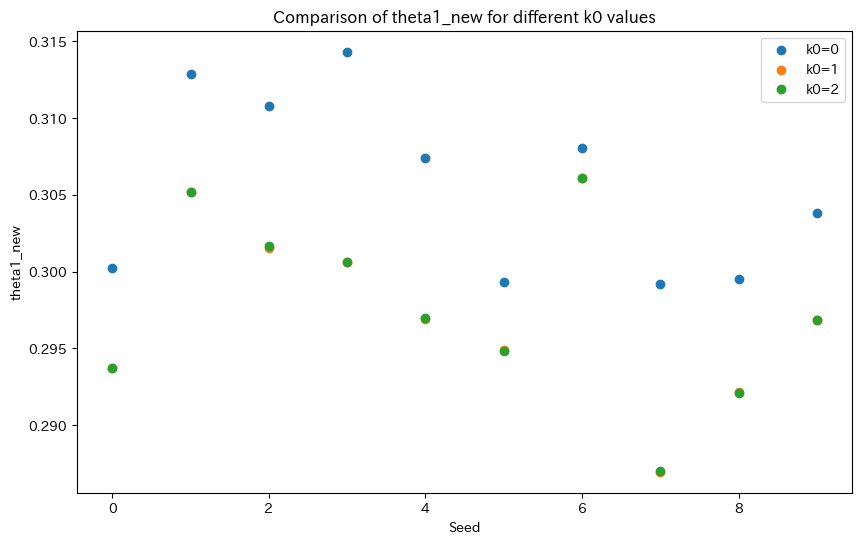

In [94]:
import numpy as np
import pandas as pd

def run_experiment(seeds, theta, t_max, dt, h):
    results = []
    
    for seed in seeds:
        Z_t = linear_Z(theta, t_max, dt, seed)
        Z = Z_t[:, ::int(h / dt)]
        theta_ = np.array([0.3, 1.5, 0.8, 0.1, 0.0])
        
        for k0 in range(3):
            theta1_new = update_1_vectorized(theta_, Z, k0, h)
            results.append({
                'seed': seed,
                'k0': k0,
                'theta1_new': theta1_new
            })
    
    return pd.DataFrame(results)

# パラメータ設定
seeds = range(10)
theta = np.array( [0.3,1.5,0.8,0.1,0.0])  # 本来のthetaの値
t_max = 10.0
dt = 0.001
h = 0.01

# 実験実行
results_df = run_experiment(seeds, theta, t_max, dt, h)

# 結果の表示
print(results_df)

# k0ごとの統計量
stats_df = results_df.groupby('k0').agg({
    'theta1_new': ['mean', 'std', 'min', 'max']
})
print("\nStatistics for each k0:")
print(stats_df)

# プロット（オプション）
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for k0 in range(3):
    k0_data = results_df[results_df['k0'] == k0]
    plt.scatter(k0_data['seed'], k0_data['theta1_new'], label=f'k0={k0}')

plt.xlabel('Seed')
plt.ylabel('theta1_new')
plt.legend()
plt.title('Comparison of theta1_new for different k0 values')
plt.show()

In [92]:
for seed in range(10):
    Z_t = linear_Z(theta, t_max, dt, seed)
    Z = Z_t[:, ::int(h / dt)]
    theta_ = np.array([0.3, 1.5, 0.8, 0.1, 0.0])
    h = 0.01
    for k0 in range(3):
        theta1_new = update_1_vectorized(theta_, Z, k0, h)


0.3002128321599351

In [3]:
# 必要な関数の定義
# aを計算する関数
def compute_a(theta, k0):
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    a0 = 1
    a1 = -theta21
    A0 = np.array([[0, 1], [-theta22 * theta3, -theta21]])
    An = np.array([np.linalg.matrix_power(A0, n) for n in np.arange(k0 + 1)])
    x0 = np.array([a0, a1])
    xn = np.einsum('ijk,k->ij', An, x0)
    return xn[:, 0]

# bを計算する関数
def compute_b(theta, k0):
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    b0 = 0
    b1 = -theta22
    B0 = np.array([[0, 1], [-theta22 * theta3, -theta21]])
    Bn = np.array([np.linalg.matrix_power(B0, n) for n in np.arange(k0 + 1)])
    x0 = np.array([b0, b1])
    xn = np.einsum('ijk,k->ij', Bn, x0)
    return xn[:, 0]

# sを計算する関数
def compute_s(a, theta, k0):
    theta1 = theta[0]
    theta3 = theta[3]
    
    m = np.arange(k0 + 1)
    k = np.arange(k0)
    l = np.arange(k0)
    
    m_grid, k_grid, l_grid = np.meshgrid(m, k, l, indexing='ij')
    valid_mask = (k_grid + l_grid == m_grid)

    m_grid = m_grid * valid_mask
    k_grid = k_grid * valid_mask
    l_grid = l_grid * valid_mask
    
    a_k = a[k_grid] * valid_mask
    a_l = a[l_grid] * valid_mask
    
    fact_11 = 1 / ((m_grid + 1) * scipy.special.factorial(k_grid) * scipy.special.factorial(l_grid))
    fact_12 = 1 / ((m_grid + 2) * scipy.special.factorial(k_grid + 1) * scipy.special.factorial(l_grid))
    fact_22 = 1 / ((m_grid + 3) * scipy.special.factorial(k_grid + 1) * scipy.special.factorial(l_grid + 1))
    
    mat11 = np.einsum('ijk->i', theta1**2 * a_k * a_l * fact_11)
    mat12 = np.einsum('ijk->i', theta1**2 * theta3 * a_k * a_l * fact_12)
    mat22 = np.einsum('ijk->i', theta1**2 * theta3**2 * a_k * a_l * fact_22)
    
    s = np.zeros((k0 + 1, 2, 2))
    s[:, 0, 0] = mat11
    s[:, 0, 1] = mat12
    s[:, 1, 0] = mat12
    s[:, 1, 1] = mat22
    
    return s

# update_2関数
def update_2(theta, Z, k0, h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    a = compute_a(theta, k0)
    b = compute_b(theta, k0)
    
    matrix = np.array([
        [np.sum(x_previous * x_previous), np.sum(x_previous * y_previous)],
        [np.sum(y_previous * x_previous), np.sum(y_previous * y_previous)]
    ])
    
    correction_x = np.sum([(a[i] * x_previous + b[i] * y_previous) * (h**i) / scipy.special.factorial(i) for i in range(2, k0 + 1)], axis=0)
    
    vector = -np.array([np.sum(x_previous * (x_current - x_previous - correction_x)),
                        np.sum(y_previous * (x_current - x_previous - correction_x))])
    
    return np.linalg.inv(matrix) @ vector / h

# update_1関数
def update_1(theta, Z, k0, h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    a = compute_a(theta, k0)
    b = compute_b(theta, k0)
    if k0 == 0:
        correction_x = 0
    else:
        correction_x = np.sum([(a[i] * x_previous + b[i] * y_previous) * (h**i) / scipy.special.factorial(i) for i in range(1, k0 + 1)], axis=0)
    
    s = compute_s(a, theta, k0)
    s_11 = s[:, 0, 0]
    correction_term = np.sum([s_11[i] * (h**i) for i in range(1, k0 + 1)])
    
    return np.sqrt(np.mean((x_current - x_previous - correction_x)**2 / h) - correction_term)

# update_3関数
def update_3(theta, Z, k0, h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    
    a = compute_a(theta, k0)
    b = compute_b(theta, k0)
    
    correction_x = np.sum([(a[i] * x_previous + b[i] * y_previous) * (h**i) / scipy.special.factorial(i) for i in range(1, k0 + 1)], axis=0)
    correction_y = np.sum([theta[3] * (a[i] * x_previous + b[i] * y_previous) * (h**(i + 1)) / scipy.special.factorial(i + 1) for i in range(1, k0 + 1)], axis=0)
    
    numerator1 = np.sum(x_previous * (y_current - y_previous - correction_y))
    numerator2 = np.sum(x_previous * (x_current - x_previous - correction_x))
    denominator = np.sum(x_previous * x_previous)
    
    if denominator == 0:
        raise ValueError("Denominator in calculation is zero, check inputs.")
    
    result = numerator1 / (denominator * h) - 2 * (theta[3] * numerator2) / (denominator * 4)
    
    return result

# update_1_final関数
def update_1_final(theta, Z, k0, h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    a = compute_a(theta, k0)
    b = compute_b(theta, k0)
    
    correction_x = np.sum([(a[i] * x_previous + b[i] * y_previous) * (h**i) / scipy.special.factorial(i) for i in range(1, k0 + 1)], axis=0)
    correction_y = np.sum([theta[3] * (a[i-1] * x_previous + b[i-1] * y_previous) * (h**i) / scipy.special.factorial(i) for i in range(1, k0 + 2)], axis=0)
    
    vec_x = h**(-1/2) * (x_current - x_previous - correction_x)
    vec_y = h**(-3/2) * (y_current - y_previous - correction_y)
    
    s = compute_s(a, theta, k0)
    S = np.sum([s[i] * h**i for i in range(1, k0 + 1)], axis=0)
    
    term1 = 2 * (np.mean(vec_x * vec_x) - S[0, 0])
    term2 = -6 * (np.mean(vec_x * vec_y) - S[0, 1]) / theta[3]
    term3 = 6 * (np.mean(vec_y * vec_y) - S[1, 1]) / theta[3]**2
    
    return np.sqrt(term1 + term2 + term3)

In [11]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 100.0
dt = 0.001
h = 0.01
n = int(t_max // h)
# 複数のseedでループ
seeds = range(400)
k0_range = range(1, 10)
theta_results = {k: [] for k in k0_range}
scaled_theta_results = {k: [] for k in k0_range}
for seed in tqdm.tqdm(seeds):
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    scaled_theta = theta.copy()
    theta_2 = update_2(theta, Z, 1, h)
    theta[1] = theta_2[0]
    theta[2] = theta_2[1]
    theta_1 = update_1(theta, Z, 1, h)
    theta[0] = theta_1
    theta_3 = update_3(theta, Z, 1, h)
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1 = update_1_final(theta, Z, k0, h)
        theta_results[k0].append(theta.copy())
        scaled_theta[0] = (theta_1-1) * np.sqrt(n)
        scaled_theta[1] = (theta_2[0]-1) * np.sqrt(n*h)
        scaled_theta[2] = (theta_2[1]-1) * np.sqrt(n*h)
        scaled_theta[3] = (theta_3 -1)* np.sqrt(n/h)
        scaled_theta_results[k0].append(scaled_theta.copy())



theta_results = {k: np.array(theta_results[k]) for k in k0_range}
scaled_theta_results = {k: np.array(scaled_theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

print(results_df)

 12%|█▏        | 48/400 [00:17<02:14,  2.62it/s]R[write to console]: 

 12%|█▏        | 48/400 [00:17<02:11,  2.67it/s]


RRuntimeError: 

In [10]:
cov_matrix

array([[ 0.26900499,  0.05870263,  0.00574828, -0.0101372 ],
       [ 0.05870263,  2.11622866,  0.04933984,  0.08406728],
       [ 0.00574828,  0.04933984,  2.02067134,  0.01073295],
       [-0.0101372 ,  0.08406728,  0.01073295,  0.14107143]])

In [4]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 1000.0
dt = 0.001
h = 0.3
n = int(t_max // h)
# 複数のseedでループ
seeds = range(40)
k0_range = range(1, 50)
theta_results = {k: [] for k in k0_range}
scaled_theta_results = {k: [] for k in k0_range}
for seed in tqdm.tqdm(seeds):
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    scaled_theta = theta.copy()
    for k0 in k0_range:
        if k0 == 1:
            theta_1 = update_1(theta, Z, 0, h)
            theta[0] = theta_1
        else:
            theta_1 = update_1(theta, Z, k0, h)
            theta[0] = theta_1
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta1 = update_1_final(theta, Z, k0, h)
        theta[0] = theta1
        theta_results[k0].append(theta.copy())
        scaled_theta[0] = (theta1-1) * np.sqrt(n)
        scaled_theta[1] = (theta_2[0]-1) * np.sqrt(n*h)
        scaled_theta[2] = (theta_2[1]-1) * np.sqrt(n*h)
        scaled_theta[3] = (theta_3 -1)* np.sqrt(n/h)
        scaled_theta_results[k0].append(scaled_theta.copy())



theta_results = {k: np.array(theta_results[k]) for k in k0_range}
scaled_theta_results = {k: np.array(scaled_theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

  2%|▎         | 1/40 [00:04<03:00,  4.64s/it]R[write to console]: 

  2%|▎         | 1/40 [00:04<03:03,  4.72s/it]


RRuntimeError: 

In [43]:
 1/6

0.16666666666666666

In [47]:
scaled_theta_results[1]

(400, 4)

In [ ]:
co

In [76]:
cov_matrix_0 = {k: [] for k in k0_range}
for k in k0_range:
    cov_matrix_0[k] = np.zeros((4, 4))
    for i in range(4):
        for j in range(4):
            cov_matrix_0[k][i, j] = np.mean(scaled_theta_results[k][:, i]  * (scaled_theta_results[k][:, j]))
cov_matrix = {k :[] for k in k0_range}
for k in k0_range:
    cov_matrix[k] = np.cov(scaled_theta_results[k].T)

In [85]:
cov_matrix[49]

array([[ 0.54834463,  0.71586394,  0.21773855, -0.10969486],
       [ 0.71586394,  6.09755749,  0.88882987,  0.77102687],
       [ 0.21773855,  0.88882987,  1.88638888, -0.02459862],
       [-0.10969486,  0.77102687, -0.02459862,  0.52011847]])

In [84]:
cov_matrix_0[49]

array([[ 0.56053719,  0.74468615,  0.19568148, -0.11099118],
       [ 0.74468615,  6.02938677,  0.83664261,  0.74446649],
       [ 0.19568148,  0.83664261,  1.84988551, -0.02139315],
       [-0.11099118,  0.74446649, -0.02139315,  0.50774525]])

In [50]:
cov_matrix_0[20]

array([[0.52121104, 0.15908472, 0.16692538, 0.2410775 ],
       [0.15908472, 2.18503637, 0.10516145, 0.1792787 ],
       [0.16692538, 0.10516145, 2.13910262, 0.16920086],
       [0.2410775 , 0.1792787 , 0.16920086, 0.39067784]])

In [ ]:
print([[np.mean(scaled_theta_results[1][:,0]*scaled_theta_results[1][:,0]), np.mean(scaled_theta_results[1][:,1]*scaled_theta_results[1][:,1]), np.mean(scaled_theta_results[1][:,2]*scaled_theta_results[1][:,2]), np.mean(scaled_theta_results[1][:,3]*scaled_theta_results[1][:,3])]])

In [32]:
scaled_theta_results

{1: array([[100.94561187,  12.74096728,  10.583834  , 997.08784307],
        [100.85652289,  13.33794649,  11.68654699, 997.8186618 ],
        [100.92272706,   9.03270654,   7.95802481, 998.18631408],
        ...,
        [102.00361432,  12.45433577,  13.33346728, 997.72879714],
        [101.09049073,   9.82457306,  11.54910284, 998.08177655],
        [101.08976666,   9.05951113,  10.04785987, 998.39670103]]),
 2: array([[ 100.71171303,   12.76936976,   10.65126151, 1000.2593094 ],
        [ 100.61485714,   13.36859316,   11.76448816, 1001.14719063],
        [ 100.75747549,    9.03378353,    7.99396786, 1000.45052014],
        ...,
        [ 101.77337286,   12.46537564,   13.41650117, 1000.84333174],
        [ 100.91517008,    9.81519897,   11.60583818, 1000.5049965 ],
        [ 100.92527304,    9.05038929,   10.0933765 , 1000.65559047]]),
 3: array([[ 100.71097752,   12.76933345,   10.65174201, 1000.27952552],
        [ 100.61406054,   13.36854439,   11.76506875, 1001.1694261 ],
     

In [44]:
np.cov(scaled_theta_results[1].T)


array([[ 0.27444652,  0.11087629,  0.00741433, -0.03464673],
       [ 0.11087629,  2.11622866,  0.04933984, -0.43678267],
       [ 0.00741433,  0.04933984,  2.02067134,  0.00216185],
       [-0.03464673, -0.43678267,  0.00216185,  0.22749848]])

In [34]:
scaled_theta_results[2]

array([[ 100.71171303,   12.76936976,   10.65126151, 1000.2593094 ],
       [ 100.61485714,   13.36859316,   11.76448816, 1001.14719063],
       [ 100.75747549,    9.03378353,    7.99396786, 1000.45052014],
       ...,
       [ 101.77337286,   12.46537564,   13.41650117, 1000.84333174],
       [ 100.91517008,    9.81519897,   11.60583818, 1000.5049965 ],
       [ 100.92527304,    9.05038929,   10.0933765 , 1000.65559047]])

In [16]:
import numpy as np
import pandas as pd

# サンプルデータを仮定して作業を進めます
# 実際のデータに基づいて `theta_results` が定義されていると仮定します。

# サンプリング数を推定
n = int(t_max//h)
# 分散共分散行列の計算
covariance_matrices = {}
for k in k0_range:
    # 各thetaに対して対応するスケールファクターを適用
    scaled_theta1 = np.sqrt(n) * theta_results[k][:, 0]
    scaled_theta21 = np.sqrt(n * h) * theta_results[k][:, 1]
    scaled_theta22 = np.sqrt(n * h) * theta_results[k][:, 2]
    scaled_theta3 = np.sqrt(h / n) * theta_results[k][:, 3]

    # 分散共分散行列を計算
    cov_matrix = np.cov([scaled_theta1, scaled_theta21, scaled_theta22, scaled_theta3], rowvar=False)
    covariance_matrices[k] = cov_matrix

# 結果の表示
for k in k0_range:
    print(f"k0 = {k}:")
    print(covariance_matrices[k], "\n")

k0 = 1:
[[146.53170159 147.40927277 145.98175051 138.78659488 135.80661395
  142.48786573 134.93537615 140.03885811 136.47124959 142.68038391
  130.47352161 138.88466619 138.68115542 133.75091927 132.51951476
  132.0421406  129.47022119 132.93747988 142.40391272 145.11707138
  132.37187248 135.69358082 137.47595555 135.3463394  133.03494545
  138.29060825 140.79182244 138.91327768 134.12022399 138.18112511]
 [147.40927277 149.01951818 146.98581737 139.70880274 135.30381412
  143.54257958 135.36690755 140.71032837 137.08987116 143.16215625
  129.8917552  139.9134638  139.5286639  133.92224071 131.95561897
  131.72613144 129.73164439 133.23857472 143.67213427 145.88130303
  132.04451653 136.12658657 137.16981946 135.79778262 133.06555954
  139.23814883 141.78963991 139.71167199 132.99931558 138.32893456]
 [145.98175051 146.98581737 145.84403169 138.14418904 135.21676794
  142.00895645 134.64972911 139.17463944 135.91102328 142.16054441
  129.86942539 138.10400289 138.16561665 133.2547962

In [14]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 300.0
dt = 0.001
h = 0.5

# 複数のseedでループ
seeds = range(30)
k0_range = range(1, 21)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        if k0 == 1:
            theta_1 = update_1(theta, Z, 0, h)
            theta[0] = theta_1
        else:
            theta_1 = update_1(theta, Z, k0, h)
            theta[0] = theta_1
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta1 = update_1_final(theta, Z, k0, h)
        theta[0] = theta1
        theta_results[k0].append(theta.copy())

theta_results = {k: np.array(theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

std_theoretical = [0.0204 0.0816 0.0816 0.0118]


,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,1.1264574,0.9748683,0.7424525,0.8717479,0.0308254,0.0667159,0.0628618,0.0158024,0.1301602,0.0712924,0.2651081,0.1292220
1,2,1.0210089,1.0516869,0.9229944,0.9677225,0.0246926,0.1079277,0.0739047,0.0133240,0.0324207,0.1196659,0.1067322,0.0349194
2,3,1.0032289,1.0589926,0.9762517,0.9932956,0.0260080,0.1212782,0.0776346,0.0133790,0.0262077,0.1348649,0.0811857,0.0149648
3,4,0.9999160,1.0452552,0.9896869,0.9981875,0.0256991,0.1270263,0.0766131,0.0134980,0.0256992,0.1348470,0.0773041,0.0136191
4,5,0.9980595,1.0361618,0.9918581,0.9990631,0.0255528,0.1285845,0.0755653,0.0135476,0.0256264,0.1335726,0.0760027,0.0135800
5,6,0.9973043,1.0315681,0.9909776,0.9991369,0.0255396,0.1284238,0.0748780,0.0135548,0.0256814,0.1322468,0.0754196,0.0135823
6,7,0.9970096,1.0296025,0.9899678,0.9990975,0.0255103,0.1279533,0.0745388,0.0135520,0.0256849,0.1313330,0.0752108,0.0135820
7,8,0.9968928,1.0288697,0.9893577,0.9990685,0.0254873,0.1275955,0.0744069,0.0135493,0.0256760,0.1308208,0.0751641,0.0135813
8,9,0.9968511,1.0286322,0.9890640,0.9990557,0.0254737,0.1273967,0.0743681,0.0135480,0.0256676,0.1305746,0.0751679,0.0135809
9,10,0.9968378,1.0285690,0.9889413,0.9990513,0.0254667,0.1273053,0.0743619,0.0135475,0.0256623,0.1304715,0.0751797,0.0135807


In [28]:
seeds = range(1)
k0_range = range(1, 21)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1_
        print(theta)

[0.9950912232564194, 0.9255855082903209, 0.9592971595886437, 0.9826110728236418]
[1.0002067887153672, 0.92129013439117, 1.0036927370416096, 1.0046748984616087]
[0.9998550752750308, 0.9193984749635631, 1.0057987683892071, 1.0057083154253406]
[0.9998292707226684, 0.9190434603935962, 1.0057669560928961, 1.005753377158737]
[0.9998275967012202, 0.919010260320774, 1.005749433726318, 1.005755363020173]
[0.9998274996658105, 0.919007990417793, 1.005747036101086, 1.0057554515619869]
[0.9998274955810161, 0.9190078928878133, 1.0057468142177566, 1.0057554555733108]
[0.9998274955223576, 0.9190078943063864, 1.0057467990151685, 1.0057554557680248]
[0.9998274955381304, 0.9190078951442626, 1.0057467983559156, 1.0057554557785813]
[0.9998274955405384, 0.9190078952511052, 1.0057467983639972, 1.0057554557792125]
[0.99982749554076, 0.9190078952604109, 1.0057467983694306, 1.005755455779251]
[0.9998274955407747, 0.9190078952609989, 1.00574679837013, 1.005755455779253]
[0.9998274955407753, 0.9190078952610192, 1

In [41]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 100.0
dt = 0.001
h = 0.01

# 複数のseedでループ
seeds = range(1,400)
k0_range = range(1, 3)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1_
        theta_results[k0].append(theta.copy())

theta_results = {k: np.array(theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.9f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

std_theoretical = [0.005000000 0.141421356 0.141421356 0.000408248]


,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,1.0045561,1.0336668,1.0153801,0.9979519,0.0054211,0.1464820,0.1494610,0.0005206,0.0070814,0.1503012,0.1502503,0.0021132
1,2,1.0052323,1.0340499,1.0206222,1.0005207,0.0054327,0.1480878,0.1502005,0.0004291,0.0075426,0.1519519,0.1516096,0.0006747


In [37]:
results_df

,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,1.0043553,1.0169207,1.0267153,0.9979529,0.0051803,0.1452979,0.1419796,0.0004764,0.0067679,0.1462799,0.1444712,0.0021018
1,2,1.0050183,1.0170738,1.0319382,1.0004859,0.0051956,0.1468303,0.1427255,0.0003755,0.0072234,0.1478196,0.1462553,0.0006141


In [38]:
0.0004764**2

2.2695695999999997e-07

In [40]:
0.0003757**2

1.4115049000000002e-07

In [39]:
1/6

0.16666666666666666

In [35]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 100.0
dt = 0.001
h = 0.01
n = t_max / h
# 複数のseedでループ
seeds = range(400)
k0_range = range(1, 3)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1_
        theta_results[k0].append(theta.copy())

theta_results = {k: np.array(theta_results[k]) for k in k0_range}

# 補正された結果の計算
corrected_theta_results = {}
for k in k0_range:
    corrected_theta = theta_results[k].copy()
    corrected_theta[:, 0] *= np.sqrt(n)
    corrected_theta[:, 1] *= np.sqrt(n * h)
    corrected_theta[:, 2] *= np.sqrt(n * h)
    corrected_theta[:, 3] *= np.sqrt(n / h)
    corrected_theta_results[k] = corrected_theta

# 補正された統計量の計算
corrected_theta_means = {k: np.mean(corrected_theta_results[k], axis=0) for k in k0_range}
corrected_theta_stds = {k: np.std(corrected_theta_results[k], axis=0) for k in k0_range}

# 結果の表示
corrected_results = []
for k in k0_range:
    mean_values = corrected_theta_means[k]
    std_values = corrected_theta_stds[k]
    
    corrected_results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3]
    })

corrected_results_df = pd.DataFrame(corrected_results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

# 結果の表示
pd.set_option('display.float_format', '{:.4f}'.format)
print(corrected_results_df)

std_theoretical = [0.0050 0.1414 0.1414 0.0004]
   k0  mean_theta1  mean_theta21  mean_theta22  mean_theta3  std_theta1  \
0   1     100.4355       10.1692       10.2672     997.9529      0.5180   
1   2     100.5018       10.1707       10.3194    1000.4859      0.5196   

   std_theta21  std_theta22  std_theta3  
0       1.4530       1.4198      0.4764  
1       1.4683       1.4273      0.3755  


In [ ]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 100.0
dt = 0.001
h = 0.01
n = t_max / h
# 複数のseedでループ
seeds = range(400)
k0_range = range(1, 3)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1_
        theta_results[k0].append(theta.copy())

theta_results = {k: np.array(theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

In [31]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 1000.0
dt = 0.01
h = 0.1

# 複数のseedでループ
seeds = range(300)
k0_range = range(1, 21)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1_
        theta_results[k0].append(theta.copy())

theta_results = {k: np.array(theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

std_theoretical = [0.0050 0.0447 0.0447 0.0013]


,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,1.0023,0.9991,0.9559,0.9800,0.0052,0.0414,0.0404,0.0016,0.0057,0.0414,0.0598,0.0201
1,2,1.0083,1.0022,1.0037,1.0039,0.0053,0.0456,0.0426,0.0014,0.0098,0.0457,0.0427,0.0041
2,3,1.0078,1.0007,1.0062,1.0051,0.0053,0.0458,0.0427,0.0014,0.0094,0.0458,0.0431,0.0053
3,4,1.0078,1.0003,1.0063,1.0052,0.0053,0.0458,0.0427,0.0014,0.0094,0.0458,0.0431,0.0054
4,5,1.0078,1.0003,1.0062,1.0052,0.0053,0.0458,0.0427,0.0014,0.0094,0.0458,0.0431,0.0054
5,6,1.0078,1.0003,1.0062,1.0052,0.0053,0.0458,0.0427,0.0014,0.0094,0.0458,0.0431,0.0054
6,7,1.0078,1.0003,1.0062,1.0052,0.0053,0.0458,0.0427,0.0014,0.0094,0.0458,0.0431,0.0054
7,8,1.0078,1.0003,1.0062,1.0052,0.0053,0.0458,0.0427,0.0014,0.0094,0.0458,0.0431,0.0054
8,9,1.0078,1.0003,1.0062,1.0052,0.0053,0.0458,0.0427,0.0014,0.0094,0.0458,0.0431,0.0054
9,10,1.0078,1.0003,1.0062,1.0052,0.0053,0.0458,0.0427,0.0014,0.0094,0.0458,0.0431,0.0054


In [21]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 300.0
dt = 0.01
h = 0.1

# 複数のseedでループ
seeds = range(300)
k0_range = range(1, 21)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1_
        theta_results[k0].append(theta.copy())

theta_results = {k: np.array(theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

std_theoretical = [0.0091 0.0816 0.0816 0.0024]


,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,1.0019,1.0070,0.9568,0.9799,0.0094,0.0703,0.0748,0.0027,0.0096,0.0707,0.0864,0.0203
1,2,1.0079,1.0111,1.0050,1.0040,0.0095,0.0776,0.0786,0.0024,0.0124,0.0784,0.0788,0.0046
2,3,1.0074,1.0096,1.0076,1.0052,0.0095,0.0780,0.0788,0.0024,0.0121,0.0786,0.0792,0.0057
3,4,1.0074,1.0093,1.0076,1.0053,0.0095,0.0780,0.0788,0.0024,0.0121,0.0785,0.0791,0.0058
4,5,1.0074,1.0092,1.0076,1.0053,0.0095,0.0780,0.0788,0.0024,0.0121,0.0785,0.0791,0.0058
5,6,1.0074,1.0092,1.0076,1.0053,0.0095,0.0780,0.0788,0.0024,0.0121,0.0785,0.0791,0.0058
6,7,1.0074,1.0092,1.0076,1.0053,0.0095,0.0780,0.0788,0.0024,0.0121,0.0785,0.0791,0.0058
7,8,1.0074,1.0092,1.0076,1.0053,0.0095,0.0780,0.0788,0.0024,0.0121,0.0785,0.0791,0.0058
8,9,1.0074,1.0092,1.0076,1.0053,0.0095,0.0780,0.0788,0.0024,0.0121,0.0785,0.0791,0.0058
9,10,1.0074,1.0092,1.0076,1.0053,0.0095,0.0780,0.0788,0.0024,0.0121,0.0785,0.0791,0.0058


In [20]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 300.0
dt = 0.01
h = 0.5

# 複数のseedでループ
seeds = range(300)
k0_range = range(1, 21)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1_
        theta_results[k0].append(theta.copy())

theta_results = {k: np.array(theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

std_theoretical = [0.0204 0.0816 0.0816 0.0118]


,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,1.0039,0.9501,0.7494,0.8665,0.0241,0.0584,0.0599,0.0129,0.0244,0.0768,0.2577,0.1341
1,2,1.0101,1.0143,0.9274,0.9574,0.0243,0.0883,0.0750,0.0138,0.0264,0.0895,0.1044,0.0448
2,3,0.9977,1.0179,0.9790,0.9811,0.0237,0.0976,0.0807,0.0149,0.0239,0.0993,0.0834,0.0241
3,4,0.9939,1.0028,0.9908,0.9853,0.0235,0.1006,0.0815,0.0153,0.0243,0.1007,0.0820,0.0212
4,5,0.9922,0.9934,0.9922,0.9860,0.0234,0.1010,0.0813,0.0154,0.0246,0.1012,0.0817,0.0208
5,6,0.9916,0.9890,0.9910,0.9860,0.0233,0.1005,0.0809,0.0154,0.0248,0.1011,0.0814,0.0208
6,7,0.9914,0.9872,0.9899,0.9860,0.0233,0.1001,0.0806,0.0154,0.0249,0.1009,0.0812,0.0208
7,8,0.9913,0.9865,0.9893,0.9859,0.0233,0.0998,0.0804,0.0154,0.0249,0.1007,0.0811,0.0209
8,9,0.9913,0.9864,0.9890,0.9859,0.0233,0.0997,0.0803,0.0154,0.0249,0.1006,0.0811,0.0209
9,10,0.9913,0.9863,0.9889,0.9859,0.0233,0.0996,0.0803,0.0154,0.0249,0.1005,0.0811,0.0209


In [19]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 300.0
dt = 0.01
h = 0.9

# 複数のseedでループ
seeds = range(300)
k0_range = range(1, 21)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1_
        theta_results[k0].append(theta.copy())

theta_results = {k: np.array(theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

std_theoretical = [0.0274 0.0816 0.0816 0.0212]


,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,1.0792,0.8992,0.5777,0.7803,0.0428,0.0483,0.0482,0.0225,0.0901,0.1118,0.4251,0.2208
1,2,1.0654,1.0612,0.8114,0.9195,0.0387,0.0912,0.0683,0.0302,0.0760,0.1098,0.2006,0.0860
2,3,1.0393,1.1229,0.9231,0.9886,0.0411,0.1103,0.0826,0.0364,0.0569,0.1652,0.1128,0.0381
3,4,1.0276,1.1123,0.9830,1.0100,0.0377,0.1261,0.0886,0.0397,0.0467,0.1688,0.0903,0.0409
4,5,1.0146,1.0911,1.0184,1.0174,0.0360,0.1374,0.0939,0.0421,0.0388,0.1649,0.0956,0.0456
5,6,1.0080,1.0673,1.0330,1.0184,0.0361,0.1427,0.0968,0.0434,0.0370,0.1578,0.1023,0.0471
6,7,1.0053,1.0464,1.0357,1.0168,0.0361,0.1439,0.0980,0.0437,0.0365,0.1512,0.1043,0.0468
7,8,1.0034,1.0308,1.0326,1.0147,0.0360,0.1425,0.0978,0.0436,0.0361,0.1458,0.1031,0.0460
8,9,1.0023,1.0203,1.0274,1.0129,0.0359,0.1400,0.0967,0.0432,0.0360,0.1415,0.1005,0.0451
9,10,1.0016,1.0141,1.0223,1.0116,0.0358,0.1372,0.0953,0.0428,0.0358,0.1380,0.0979,0.0444


In [29]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 300.0
dt = 0.01
h = 0.9

# 複数のseedでループ
seeds = range(300)
k0_range = range(1, 51)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1_
        theta_results[k0].append(theta.copy())

theta_results = {k: np.array(theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

std_theoretical = [0.0274 0.0816 0.0816 0.0212]


,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,1.0792,0.8992,0.5777,0.7803,0.0428,0.0483,0.0482,0.0225,0.0901,0.1118,0.4251,0.2208
1,2,1.0654,1.0612,0.8114,0.9195,0.0387,0.0912,0.0683,0.0302,0.0760,0.1098,0.2006,0.0860
2,3,1.0393,1.1229,0.9231,0.9886,0.0411,0.1103,0.0826,0.0364,0.0569,0.1652,0.1128,0.0381
3,4,1.0276,1.1123,0.9830,1.0100,0.0377,0.1261,0.0886,0.0397,0.0467,0.1688,0.0903,0.0409
4,5,1.0146,1.0911,1.0184,1.0174,0.0360,0.1374,0.0939,0.0421,0.0388,0.1649,0.0956,0.0456
5,6,1.0080,1.0673,1.0330,1.0184,0.0361,0.1427,0.0968,0.0434,0.0370,0.1578,0.1023,0.0471
6,7,1.0053,1.0464,1.0357,1.0168,0.0361,0.1439,0.0980,0.0437,0.0365,0.1512,0.1043,0.0468
7,8,1.0034,1.0308,1.0326,1.0147,0.0360,0.1425,0.0978,0.0436,0.0361,0.1458,0.1031,0.0460
8,9,1.0023,1.0203,1.0274,1.0129,0.0359,0.1400,0.0967,0.0432,0.0360,0.1415,0.1005,0.0451
9,10,1.0016,1.0141,1.0223,1.0116,0.0358,0.1372,0.0953,0.0428,0.0358,0.1380,0.0979,0.0444
